In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
#plotting and animation libraries
import matplotlib.pyplot as plt
import seaborn as sns
#clustering libraries
import scipy
import scipy.cluster as cl
import sklearn.cluster as skcl
import sklearn.metrics as skm
#pca library
import sklearn.decomposition as skd
import argparse
import datetime

#My libraries
import LLSA as lvar
import LLSA_calculations as lvarc

In [2]:
#mask nans if they are present
tseries_w=ma.masked_invalid(np.array(np.load('worm_tseries.npy'),dtype=np.float64))

In [3]:
f=h5py.File('worm_tseries.h5','r')
worms=np.sort(np.array(list(f.keys()),dtype=int))
tseries_w=[]
for worm in worms:
    f_worm=f[str(worm)]
    ts_=ma.masked_invalid(np.array(f_worm['tseries'],dtype=np.float64))
    frameRate=np.array(f_worm['frameRate'],dtype=float)[0]
    tseries_w.append(ts_)
f.close()

# Estimate the minimum window using the condition number

The condition number of the covariance matrix of the data and the error serves as guidance for choosing the minimum window size. It tells us when the least squares regression in well-conditioned, which corresponds to a drop in the condition number (high condition numbers indicate near-singularity)

In [4]:
guess_dims=7
range_minw=np.arange(guess_dims+1,6*guess_dims)
conds_w=[]
conds_cov_w=[]
n_windows_per_worm=100
for window in range_minw:
    conds=[]
    conds_cov=[]
    for worm in range(len(tseries_w)):
        tseries=tseries_w[worm]
        while len(conds)<n_windows_per_worm:
            start_t=np.random.randint(0,len(tseries))
            ts=tseries[start_t:start_t+window]
            if ma.count_masked(ts)==0 and len(ts)==window:
                conds.append(np.linalg.cond(np.cov(ts.T)))
                theta,eps=lvarc.get_theta(ts,1)
                inter,coef,cov=lvarc.decomposed_theta(theta)
                conds_cov.append(np.linalg.cond(cov)) 
    conds_w.append(np.hstack(conds))
    conds_cov_w.append(np.hstack(conds_cov))

In [5]:
def bootstrap(l,n_times,n_samples=1000,confidence_interval=95):
    if n_samples>len(l):
        n_samples=len(l)*2
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),n_samples)#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.median(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.median(l,axis=0),cil,ciu

In [6]:
median_w=[]
median_cil_w=[]
median_ciu_w=[]
median_cov_w=[]
median_cil_cov_w=[]
median_ciu_cov_w=[]
for k in range(len(conds_w)):
    median,cil,ciu=bootstrap(conds_w[k],100)
    median_w.append(median)
    median_cil_w.append(cil)
    median_ciu_w.append(ciu)
    median,cil,ciu=bootstrap(conds_cov_w[k],100)
    median_cov_w.append(median)
    median_cil_cov_w.append(cil)
    median_ciu_cov_w.append(ciu)

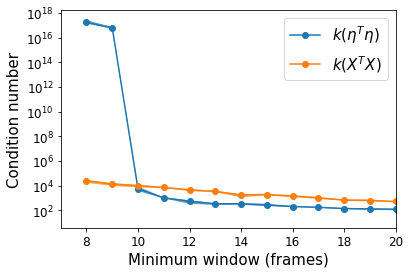

In [7]:
plt.plot(range_minw,np.hstack(median_cov_w),marker='o',label='$k(\eta^T\eta)$')
plt.fill_between(range_minw,np.hstack(median_cil_cov_w),np.hstack(median_ciu_cov_w),alpha=.7)
plt.plot(range_minw,np.hstack(median_w),marker='o',label='$k(X^TX)$')
plt.fill_between(range_minw,np.hstack(median_cil_w),np.hstack(median_ciu_w),alpha=.7)
plt.ylabel('Condition number',fontsize=15)
plt.xlabel('Minimum window (frames)',fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(guess_dims,20)
plt.legend(fontsize=15)
plt.show()

In [8]:
#the value of w0 should be guided by the previous plot
w0=10
step_fraction=.1
i=w0
w=[]
while i < np.inf:
    w.append(i)
    step=int(i*step_fraction)
    if int(i*step_fraction)>w0:
        break
    if step<1:
        step=1
    i+=step

### Sample time series 

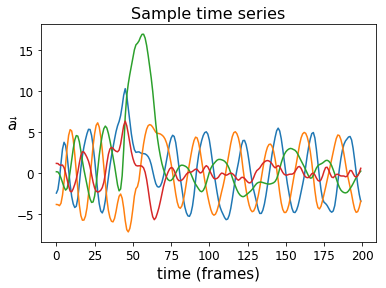

In [9]:
worm_IDX=0
plt.title('Sample time series',fontsize=16)
plt.plot(tseries_w[worm_IDX])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time (frames)',fontsize=15)
plt.ylabel(r'$\vec{a}$',fontsize=15,rotation=0)
plt.show()

# Adaptive segmentation

In [10]:
N=1000
per=97.5
sample_tseries=tseries_w[worm_IDX]
#apply segmentation algorithm
breaks_segments=lvar.change_point(w,N,per,sample_tseries,20)

In [11]:
windows_segment,segments=breaks_segments
#compute thetas in the obtained windows_segment
thetas_final=[]
for idx,seg in enumerate(segments):
    segment_windows=np.copy(windows_segment[idx])
    segments_windows=list(segment_windows)
    thetas=[]
    for seg_w in segment_windows:
        i_0,i_f=seg_w
        window_bw=sample_tseries[i_0:i_f]
        theta,eps=lvarc.get_theta(window_bw,1)
        thetas.append(np.vstack(theta))
    thetas_final.append(thetas)
thetas_final=np.concatenate(thetas_final)
windows_final=np.concatenate(windows_segment)

# Eigenvalue spectrum

In [12]:
all_eigs=[]
for theta in thetas_final:
    c,A,cov=lvarc.decomposed_theta(theta)
    coef=(A-np.identity(theta.shape[1]))*frameRate
    all_eigs.append(np.linalg.eigvals(coef))

### In case you don't have the seaborn package, you can use this piece of code 

In [13]:
# from scipy import ndimage as ndi
# import matplotlib.cm as cm
# import matplotlib.colors as colors

# def density_plot(X,Y,xrange,yrange,n_grid_x,n_grid_y,border=5,smooth=False,log=False):
#     # view area range
#     view_xmin,view_xmax=xrange
#     view_ymin,view_ymax=yrange

#     # get data
#     xl = X
#     yl = Y

#     # get visible data points
#     xlvis = []
#     ylvis = []
#     for i in range(0,len(xl)):
#         if view_xmin < xl[i] < view_xmax and view_ymin < yl[i] < view_ymax:
#             xlvis.append(xl[i])
#             ylvis.append(yl[i])

#     kx = (n_grid_x - 1) / (view_xmax - view_xmin)
#     ky = (n_grid_y - 1) / (view_ymax - view_ymin)
#     imgw = (n_grid_x + 2 * border)
#     imgh = (n_grid_y + 2 * border)
#     img = np.zeros((imgh,imgw))
#     for x, y in zip(xl,yl):
#         ix = int((x - view_xmin) * kx) + border
#         iy = int((y - view_ymin) * ky) + border
#         if 0 <= ix < imgw and 0 <= iy < imgh:
#             img[iy][ix] += 1
#     if smooth:
#         if log:
#             log_img=np.log10(img)
#             sel=~np.isfinite(log_img)
#             log_img[sel]=0.
#             filtered_img=ndi.gaussian_filter(log_img, (border,border))
#             return filtered_img
#         else:
#             return ndi.gaussian_filter(img, (border,border))  ## gaussian convolution
#     else:
#         if log:
#             return np.log10(img)
#         else:
#             return img


In [14]:
# xrange=[-5,3]
# yrange=[-1.5,1.5]
# r=6
# n_grid=256

# density=density_plot(np.hstack(all_eigs).real,np.hstack(all_eigs).imag/(2*np.pi),xrange,yrange,n_grid,n_grid,border=r,smooth=True)
# data=density/density.max()
# plt.imshow(data , origin='lower', extent=[xrange[0], xrange[1], yrange[0], yrange[1]],cmap=cm.jet,
#            aspect=2)#,norm=colors.SymLogNorm(linthresh=0.4, linscale=1e-1,vmin=data.min(), vmax=data.max()))#
# plt.colorbar()
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.xlabel(' $\lambda_r$',fontsize=20)
# plt.ylabel('$\lambda_i$',fontsize=20)
# plt.axvline(0,ls='--')
# plt.grid(False)
# #     plt.savefig('a3_a3dot_state_{}.eps'.format(cluster_idx))
# plt.show()

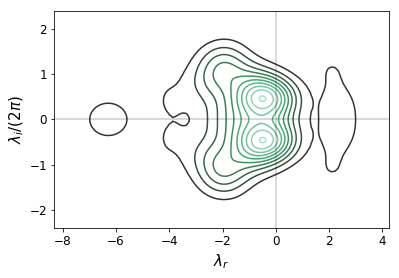

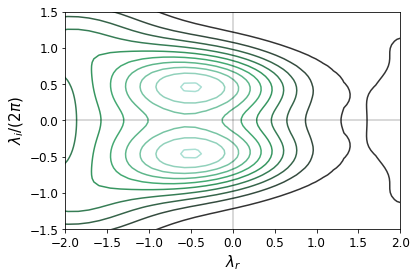

In [15]:
sns.kdeplot(np.hstack(all_eigs).real,np.hstack(all_eigs).imag/(2*np.pi))
plt.axhline(0,c='k',alpha=.2)
plt.axvline(0,c='k',alpha=.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\lambda_r$',fontsize=15)
plt.ylabel('$\lambda_i/(2\pi)$',fontsize=15)
plt.show()

sns.kdeplot(np.hstack(all_eigs).real,np.hstack(all_eigs).imag/(2*np.pi))
plt.axhline(0,c='k',alpha=.2)
plt.axvline(0,c='k',alpha=.2)
plt.xlim(-2,2)
plt.ylim(-1.5,1.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\lambda_r$',fontsize=15)
plt.ylabel('$\lambda_i/(2\pi)$',fontsize=15)
plt.show()

# Likelihood hierarchical clustering

In [16]:
def compute_master_theta(models,windows_w,tseries_w):
    master_tseries=[]
    for model in models:
        worm,window_idx=model
        window=windows_w[window_idx]
        t0,tf=window
        ts=tseries_w[worm][t0:tf]
        master_tseries.append(ts)
        master_tseries.append([np.nan]*ts.shape[1])
    master_tseries=ma.masked_invalid(ma.vstack(master_tseries))
    master_theta,eps=lvarc.get_theta_masked(master_tseries)
    return master_theta

def likelihood_distance(models,windows_w,tseries_w,thetas_w):
    master_theta=compute_master_theta(models,windows_w,tseries_w)
    distances=[]
    for model in models:
        worm_idx,model_idx=model
        theta=thetas_w[model_idx]
        window=windows_w[model_idx]
        t0,tf=window
        ts=ma.masked_invalid(tseries_w[worm_idx][t0:tf])
        theta_here,eps=lvarc.get_theta(ts)
        distances.append(lvarc.loglik_mvn_masked(theta,ts)-lvarc.loglik_mvn_masked(master_theta,ts))
    return np.sum(distances)

In [17]:
windows=windows_final
all_models=[]
for kw,window in enumerate(windows):
    all_models.append([worm_IDX,kw])
all_models=np.vstack(all_models)

## Compute dissimilarity matrix 

In [18]:
modelx_i=0
modelx_f=len(all_models)
modely_i=0
modely_f=len(all_models)


n_modelsx=modelx_f-modelx_i
n_modelsy=modely_f-modely_i
dissimilarity_matrix=np.zeros((n_modelsx,n_modelsy))
indices=np.array([[modelx_i,modelx_f],[modely_i,modely_f]])
for idx1,idx_model1 in enumerate(np.arange(modelx_i,modelx_f)):
    for idx2,idx_model2 in enumerate(np.arange(modely_i,modely_f)):
        model1=all_models[idx_model1]
        model2=all_models[idx_model2]
        models_=np.vstack((model1,model2))
        dist=likelihood_distance(models_,windows_final,tseries_w,thetas_final)
        dissimilarity_matrix[idx1,idx2]=dist

### Ensure symmetrization before applying Ward's method 

In [19]:
def symmetrize(a):
    return (a + a.T)/2 - np.diag(a.diagonal())

In [20]:
sym_dissimilarity_matrix=symmetrize(dissimilarity_matrix)

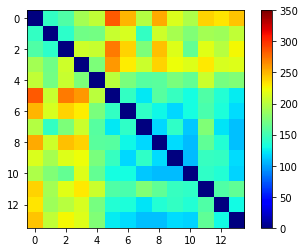

In [21]:
plt.imshow(sym_dissimilarity_matrix,cmap='jet',vmin=0,vmax=350)
plt.colorbar()
plt.show()

In [22]:
#load clustering packages
import scipy.cluster as cl
import scipy.spatial.distance as ssd

In [23]:
#turn distance matrix into a vector
pdist=ssd.squareform(sym_dissimilarity_matrix,force='tovector')
#perform hierarchical clustering using Ward's method
Z=cl.hierarchy.ward(pdist)

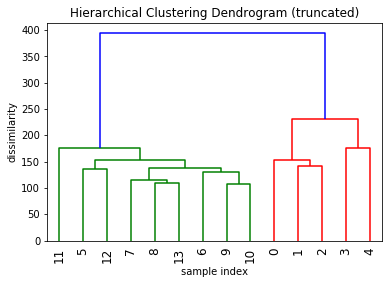

In [24]:
from scipy.cluster.hierarchy import dendrogram

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('dissimilarity')
ddgram=dendrogram(
    Z,
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.grid(False)
plt.show()

#### Organize distance matrix according to the clustering

In [25]:
import scipy.cluster.hierarchy as sch
def seriation(Z,N,cur_index):
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,Z=0,method="ward",precomputed=False):
    N = len(dist_mat)
    if precomputed:
        res_linkage = Z
    else:
        flat_dist_mat = ssd.squareform(dist_mat)
        res_linkage=sch.linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

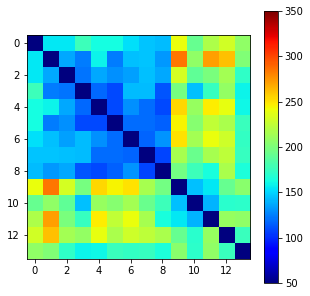

In [26]:
seriated_dist,res_order,res_linkage=compute_serial_matrix(sym_dissimilarity_matrix,Z=Z,precomputed=True)
plt.figure(figsize=(5,5))
plt.imshow(seriated_dist,cmap='jet',vmin=50,vmax=350)
plt.grid(False)
plt.colorbar()
plt.show()

### Num clusters as a function of dissimilarity 

In [27]:
from scipy.cluster.hierarchy import fcluster
n_clusters=[]
for max_d in np.arange(0,400,5):
    cluster_labels = fcluster(Z, max_d, criterion='distance')
    n_clusters.append(len(np.unique(cluster_labels)))

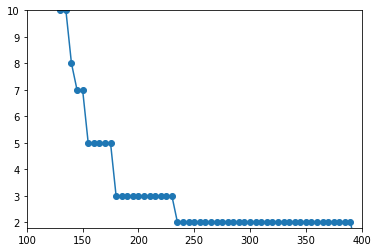

In [28]:
plt.plot(np.arange(0,400,5),n_clusters,marker='o')
plt.xlim(100,400)
plt.ylim(1.8,10)
plt.show()

### Label each model according to the clustering

In [29]:
from scipy.cluster.hierarchy import fcluster
k = 3
cluster_labels = fcluster(Z, k, criterion='maxclust')
cluster_labels

array([2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

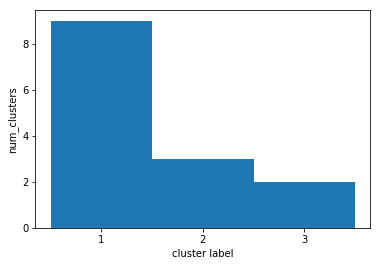

In [30]:
plt.hist(cluster_labels,range=[.5,np.max(cluster_labels)+.5],bins=np.max(cluster_labels))
plt.xticks([1,2,3])
plt.ylabel('num_clusters')
plt.xlabel('cluster label')
plt.show()

## Understanding the clusters 

In [31]:
from scipy.interpolate import CubicSpline

def unwrapma(x):
    idx= ma.array(np.arange(0,x.shape[0]),mask=x.mask)
    idxc=idx.compressed()
    xc=x.compressed()
    dd=np.diff(xc)
    ddmod=np.mod(dd+np.pi,2*np.pi)-np.pi
    ddmod[(ddmod==-np.pi)&(dd>0)]=np.pi
    phc_correct = ddmod-dd
    phc_correct[np.abs(dd)<np.pi] = 0
    ph_correct = np.zeros(x.shape)
    ph_correct[idxc[1:]] = phc_correct
    up = x + ph_correct.cumsum()
    return up

def compute_phi_omega_a3(tseries,t0,tf,frameRate=16.):
    time=np.arange(t0,tf)
    X=tseries[time]
    phi=-np.arctan2(X[:,1],X[:,0])
    cs = CubicSpline(time, phi)
    phiFilt=cs(time)
    phi_unwrap=unwrapma(phi)
    sel=~phi_unwrap.mask
    cs = CubicSpline(time[sel], phi_unwrap[sel])
    #normalize by frame rate
    phiFilt_unwrap=cs(time[sel])
    omegaFilt=cs(time[sel],1)*frameRate/(2*np.pi)
    return phiFilt,omegaFilt,X[:,2]

In [32]:
#omega is the phase velocity and it effectively measures the velocity of the body wave
#a_3 measures the turning amplitude

In [33]:
omegas_cluster=[]
a3s_cluster=[]
for idx in range(1,np.max(cluster_labels)+1):
    indices=np.arange(len(cluster_labels))[cluster_labels==idx]
    omegas=[]
    a3s=[]
    for model in all_models[indices]:
        worm,kw=model
        window=windows_final[kw]
        t0,tf=window
        tseries=tseries_w[worm]
        phi,omega,a3=compute_phi_omega_a3(tseries,t0,tf)
        omegas.append(omega)
        a3s.append(a3)
    omegas_cluster.append(np.hstack(omegas))
    a3s_cluster.append(np.hstack(a3s))

In [34]:
[np.mean(omegas) for omegas in omegas_cluster]

[0.66495738105068902, -0.91339099529375867, -0.2609563044728237]

In [35]:
[np.mean(a3s) for a3s in a3s_cluster]

[-0.0096933227032423019, 1.0476439283474495, 9.8949923698718738]

In [45]:
#run this if you don't have seaborn

In [43]:
# for idx in range(np.max(cluster_labels)):
#     plt.hist(omegas_cluster[idx],label='state '+str(idx+1),range=[-2,2],bins=50,alpha=.2,density=True)
# plt.xlim(-2,2)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('$\omega$',fontsize=15)
# plt.ylabel('PDF',fontsize=15)
# plt.show()

In [44]:
# for idx in range(np.max(cluster_labels)):
#     plt.hist(a3s_cluster[idx],label='state '+str(idx+1),range=[-30,30],bins=50,alpha=.2,density=True)
# plt.xlim(-30,30)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('$a_3$',fontsize=15)
# plt.ylabel('PDF',fontsize=15)
# plt.show()

In [36]:
import seaborn as sns

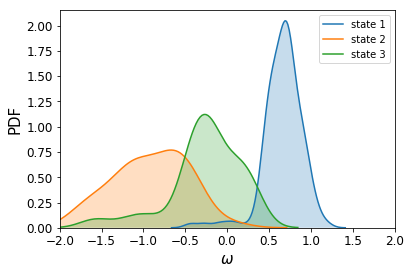

In [37]:
for idx in range(np.max(cluster_labels)):
    sns.kdeplot(omegas_cluster[idx],shade=True,label='state '+str(idx+1))
plt.xlim(-2,2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\omega$',fontsize=15)
plt.ylabel('PDF',fontsize=15)
plt.show()

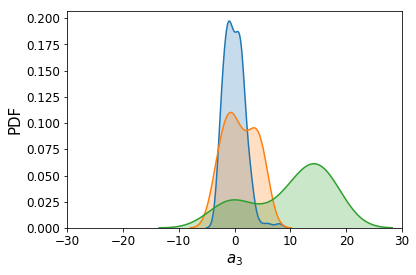

In [38]:
for idx in range(np.max(cluster_labels)):
    sns.kdeplot(a3s_cluster[idx],shade=True)
plt.xlim(-30,30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$a_3$',fontsize=15)
plt.ylabel('PDF',fontsize=15)
plt.show()

## You can also distinguish behavior by simply looking at the linear couplings and mean values 

In [46]:
def master_theta_class(models,windows_w,tseries_w):
    master_tseries=[]
    for model in models:
        worm,window_idx=model
        window=windows_w[window_idx]
        t0,tf=window
        ts=tseries_w[worm][t0:tf]
        master_tseries.append(ts)
        master_tseries.append([np.nan]*ts.shape[1])
    master_tseries=ma.masked_invalid(ma.vstack(master_tseries))
    master_theta,eps=lvarc.get_theta_masked(master_tseries)
    return master_tseries,master_theta

In [47]:
master_eigs=[]
master_thetas=[]
master_coefs=[]
for idx in range(1,np.max(cluster_labels)+1):
    indices=np.arange(len(cluster_labels))[cluster_labels==idx]
    master_tseries,master_theta_state=master_theta_class(all_models[indices],windows_final,tseries_w)
    mean=np.mean(master_tseries,axis=0)
    c,A,cov=lvarc.decomposed_theta(master_theta_state)
    coef=(A-np.identity(4))*frameRate
    eigs=np.linalg.eig(coef)[0]
    master_eigs.append(eigs)
    master_thetas.append(np.vstack((mean,coef)))
    master_coefs.append(coef)

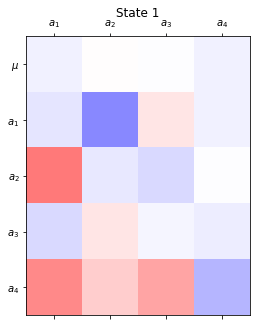

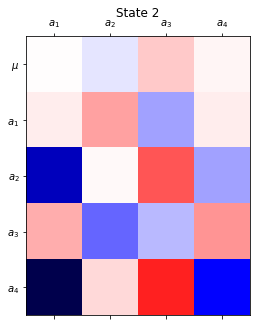

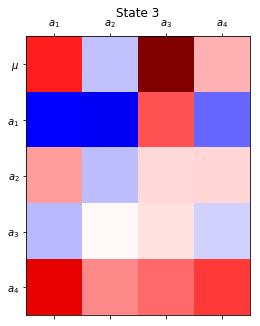

In [48]:
k=1
for theta in master_thetas:
    plt.matshow(theta,cmap='seismic',vmin=-10,vmax=10)
    plt.title('State '+str(k))
    plt.xticks(range(4),['$a_1$','$a_2$','$a_3$','$a_4$'])
    plt.yticks(range(5),['$\mu$','$a_1$','$a_2$','$a_3$','$a_4$'])
    plt.show()
    k+=1